In [49]:
import sys
import pandas as pd
import numpy as np
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict

In [2]:
# Define colors for consistency
COLORS = {
    'Random': '#ff7f0e',  # Orange
    'Random Walk': '#1f77b4',  # Blue
    'Greedy': '#2ca02c',  # Green
    'Steepest': '#d62728',  # Red
    'Heuristic': '#9467bd'   # Purple
}

In [3]:
def clean_solution(solution_str):
    solution = solution_str.strip('[]').split()
    return [int(x) for x in solution]

csv_path= "results/results_2025-04-03T09_23.csv"  # Change this to your CSV path
df = pd.read_csv(csv_path)
df["Solution"] = df["Solution"].apply(clean_solution)
df.head()

,Instance,Solver,Run,InitialFitness,FinalFitness,TimeMs,Steps,Evaluations,SolutionsChecked,Solution
0,chr12b.dat,Steepest,1,43194,16616,0.0,10,660,660,"[5, 10, 8, 11, 9, 3, 1, 6, 2, 7, 0, 4]"
1,chr12b.dat,Steepest,2,46854,9742,0.0,9,594,594,"[4, 6, 0, 9, 10, 2, 3, 1, 8, 5, 11, 7]"
2,chr12b.dat,Steepest,3,52064,15398,0.0,9,594,594,"[9, 7, 5, 1, 6, 0, 10, 3, 2, 4, 11, 8]"
3,chr12b.dat,Steepest,4,49026,15384,0.0,10,660,660,"[6, 4, 10, 9, 3, 0, 7, 11, 8, 5, 1, 2]"
4,chr12b.dat,Steepest,5,41224,20452,0.0,10,660,660,"[8, 11, 10, 3, 6, 1, 5, 7, 2, 4, 9, 0]"


In [4]:
df

,Instance,Solver,Run,InitialFitness,FinalFitness,TimeMs,Steps,Evaluations,SolutionsChecked,Solution
0,chr12b.dat,Steepest,1,43194,16616,0.0,10,660,660,"[5, 10, 8, 11, 9, 3, 1, 6, 2, 7, 0, 4]"
1,chr12b.dat,Steepest,2,46854,9742,0.0,9,594,594,"[4, 6, 0, 9, 10, 2, 3, 1, 8, 5, 11, 7]"
2,chr12b.dat,Steepest,3,52064,15398,0.0,9,594,594,"[9, 7, 5, 1, 6, 0, 10, 3, 2, 4, 11, 8]"
3,chr12b.dat,Steepest,4,49026,15384,0.0,10,660,660,"[6, 4, 10, 9, 3, 0, 7, 11, 8, 5, 1, 2]"
4,chr12b.dat,Steepest,5,41224,20452,0.0,10,660,660,"[8, 11, 10, 3, 6, 1, 5, 7, 2, 4, 9, 0]"
...,...,...,...,...,...,...,...,...,...,...
11995,bur26a.dat,Steepest,296,5933610,5447505,4.0,24,7800,7800,"[10, 13, 11, 1, 17, 14, 23, 15, 0, 7, 18, 2, 6..."
11996,bur26a.dat,Steepest,297,6092007,5438541,5.0,25,8125,8125,"[3, 11, 1, 6, 12, 5, 25, 2, 14, 0, 18, 17, 19,..."
11997,bur26a.dat,Steepest,298,6024625,5441395,5.0,24,7800,7800,"[3, 11, 25, 6, 10, 14, 23, 15, 0, 7, 19, 17, 1..."
11998,bur26a.dat,Steepest,299,5837367,5441486,4.0,20,6500,6500,"[14, 6, 2, 3, 10, 21, 12, 5, 7, 17, 4, 20, 0, ..."


In [5]:
def load_optimal_solution(instance_name):
    base_name = os.path.splitext(instance_name)[0]
    sln_path = f"instances/{base_name}.sln"

    try:
        with open(sln_path, 'r') as f:
            lines = f.readlines()
            _, optimal_fitness = map(int, lines[0].strip().split())
            optimal_solution = []
            for line in lines[1:]:
                optimal_solution.extend(map(int, line.strip().split()))
            return optimal_fitness, optimal_solution
    except:
        return None

instances = df['Instance'].unique()
best_solution_fitness = {}
best_solutions = {}

for instance in instances:
    result = load_optimal_solution(instance)
    if result:
        best_solution_fitness[instance], best_solutions[instance] = result


In [6]:
def load_optimal_solution(instance_name):
    base_name = os.path.splitext(instance_name)[0]
    sln_path = f"instances/{base_name}.sln"

    try:
        with open(sln_path, 'r') as f:
            lines = f.readlines()
            _, optimal_fitness = map(int, lines[0].strip().split())
            optimal_solution = []
            for line in lines[1:]:
                optimal_solution.extend(map(int, line.strip().split()))
            return optimal_fitness, optimal_solution
    except:
        return None

instances = df['Instance'].unique()
best_solution_fitness = {}
best_solutions = {}

for instance in instances:
    result = load_optimal_solution(instance)
    if result:
        best_solution_fitness[instance], best_solutions[instance] = result

In [7]:
df['GapToBest'] = df.apply(lambda row: 
    (row['FinalFitness'] - best_solution_fitness.get(row['Instance'], row['FinalFitness'])) / 
    best_solution_fitness.get(row['Instance'], row['FinalFitness']) * 100, axis=1)

df['ImprovementPercent'] = ((df['InitialFitness'] - df['FinalFitness']) / df['InitialFitness']) * 100
df['EvalsPerSecond'] = df['Evaluations'] / ((df['TimeMs'] / 1000) + 1e-9)
df['Efficiency'] = df['EvalsPerSecond'] / (df['FinalFitness'] + 1e-9)
df.head()

,Instance,Solver,Run,InitialFitness,FinalFitness,TimeMs,Steps,Evaluations,SolutionsChecked,Solution,GapToBest,ImprovementPercent,EvalsPerSecond,Efficiency
0,chr12b.dat,Steepest,1,43194,16616,0.0,10,660,660,"[5, 10, 8, 11, 9, 3, 1, 6, 2, 7, 0, 4]",70.560460,61.531694,6.600000e+11,3.972075e+07
1,chr12b.dat,Steepest,2,46854,9742,0.0,9,594,594,"[4, 6, 0, 9, 10, 2, 3, 1, 8, 5, 11, 7]",0.000000,79.207752,5.940000e+11,6.097311e+07
2,chr12b.dat,Steepest,3,52064,15398,0.0,9,594,594,"[9, 7, 5, 1, 6, 0, 10, 3, 2, 4, 11, 8]",58.057894,70.424862,5.940000e+11,3.857644e+07
3,chr12b.dat,Steepest,4,49026,15384,0.0,10,660,660,"[6, 4, 10, 9, 3, 0, 7, 11, 8, 5, 1, 2]",57.914186,68.620732,6.600000e+11,4.290172e+07
4,chr12b.dat,Steepest,5,41224,20452,0.0,10,660,660,"[8, 11, 10, 3, 6, 1, 5, 7, 2, 4, 9, 0]",109.936358,50.388123,6.600000e+11,3.227068e+07


In [30]:
best_solutions


{
    'chr12b.dat': [5, 7, 1, 10, 11, 3, 4, 2, 9, 6, 12, 8],
    'chr22a.dat': [15, 2, 21, 8, 16, 1, 7, 18, 14, 13, 5, 17, 6, 11, 3, 4, 20, 19, 9, 22, 10, 12],
    'chr22b.dat': [10, 19, 3, 1, 20, 2, 6, 4, 7, 8, 17, 12, 11, 15, 21, 13, 9, 5, 22, 14, 18, 16],
    'esc32f.dat': [
        1,
        2,
        5,
        6,
        8,
        16,
        13,
        19,
        9,
        32,
        7,
        22,
        24,
        20,
        4,
        12,
        3,
        17,
        29,
        21,
        11,
        25,
        27,
        18,
        30,
        31,
        23,
        28,
        14,
        15,
        26,
        10
    ],
    'esc32g.dat': [
        14,
        15,
        16,
        12,
        11,
        26,
        30,
        10,
        25,
        8,
        29,
        22,
        31,
        28,
        13,
        1,
        19,
        9,
        17,
        32,
        24,
        18,
        4,
        2,
        20,
        5,
        21,
 

In [8]:
def analyze_qap_results(df):
    instances = df['Instance'].unique()
    
    best_solution_fitness = {}
    best_solutions = {}
    
    for instance in instances:
        best_solution_fitness[instance], best_solutions[instance] = load_optimal_solution(instance)

    # Add gap to best known solution
    df['GapToBest'] = df.apply(lambda row: (row['FinalFitness'] - best_solution_fitness[row['Instance']]) / best_solution_fitness[row['Instance']] * 100, axis=1)
    
    # Add improvement percentage
    df['ImprovementPercent'] = ((df['InitialFitness'] - df['FinalFitness']) / df['InitialFitness'] * 100)
    
    # Add evaluations per second
    df['EvalsPerSecond'] = df['Evaluations'] / ((df['TimeMs'] / 1000) + 1e-9)
    
    return df
df = analyze_qap_results(df)

/tmp/ipykernel_14899/514064891.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  instance_order = df.groupby("Instance")["GapToBest"].mean().sort_values().index
/tmp/ipykernel_14899/514064891.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gap_stats = df.groupby(['Instance', 'Solver'])['GapToBest'].agg(['mean', 'std']).reset_index()


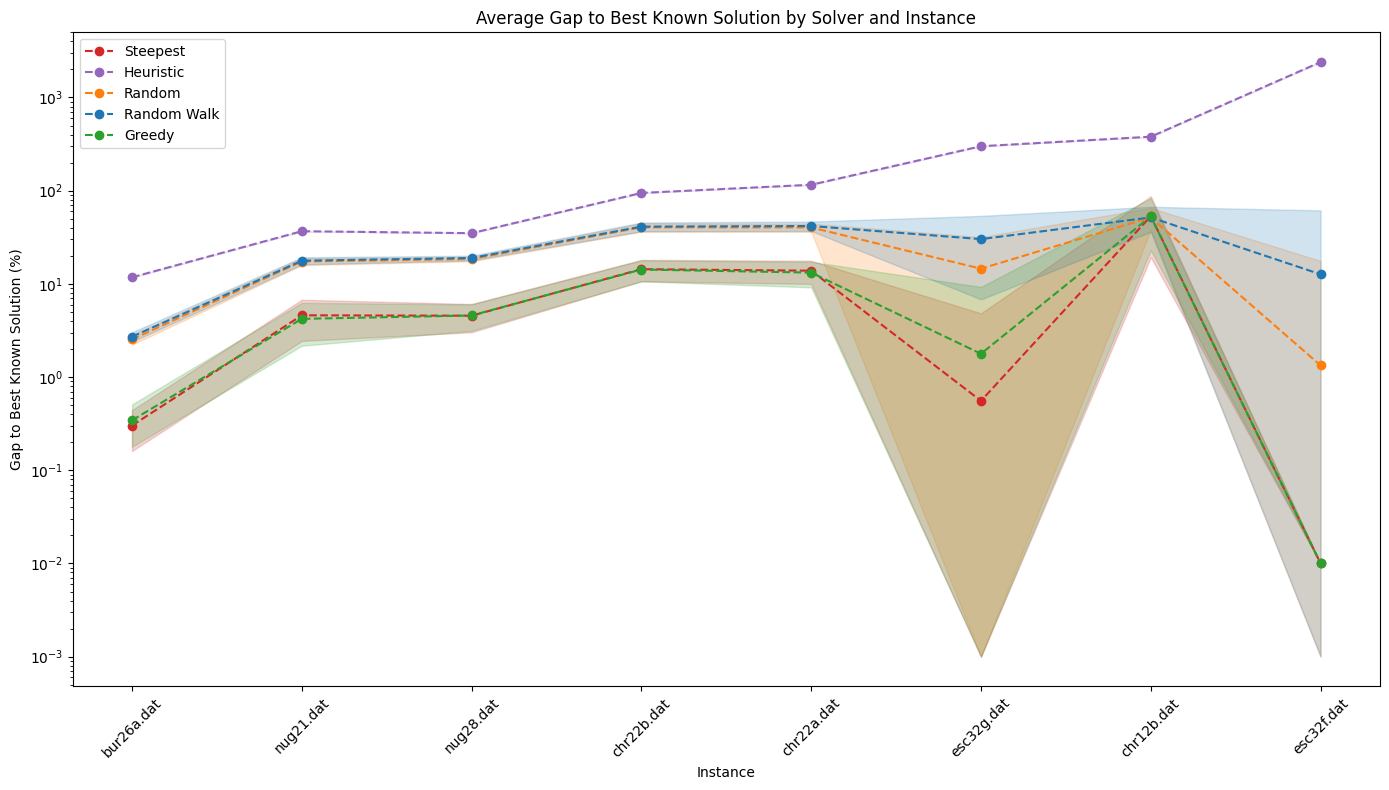

In [12]:
def plot_gap_to_best(df):
    plt.figure(figsize=(14, 8))

    # Order instances by mean GapToBest
    instance_order = df.groupby("Instance")["GapToBest"].mean().sort_values().index
    df["Instance"] = pd.Categorical(df["Instance"], categories=instance_order, ordered=True)
    instances = list(instance_order)

    # Calculate mean and std by instance and solver
    gap_stats = df.groupby(['Instance', 'Solver'])['GapToBest'].agg(['mean', 'std']).reset_index()
    solvers = df['Solver'].unique()

    for solver in solvers:
        means = []
        stds = []
        for instance in instances:
            filtered = gap_stats[(gap_stats["Instance"] == instance) & (gap_stats["Solver"] == solver)]
            if not filtered.empty:
                mean_val = filtered["mean"].values[0]
                std_val = filtered["std"].values[0]
                means.append(mean_val if mean_val > 0 else mean_val + 1e-2)
                stds.append(std_val)
            else:
                means.append(np.nan)
                stds.append(0)

        x = np.arange(len(instances))
        means = np.array(means)
        stds = np.array(stds)
        lower = means - stds
        upper = means + stds

        # Ensure all y values are positive for log scale
        lower = np.where(lower <= 0, 1e-3, lower)

        plt.plot(x, means, label=solver, color=COLORS[solver], linestyle='--', marker='o')
        plt.fill_between(x, lower, upper, color=COLORS[solver], alpha=0.2)

    plt.xlabel('Instance')
    plt.ylabel('Gap to Best Known Solution (%)')
    plt.title('Average Gap to Best Known Solution by Solver and Instance')
    plt.xticks(np.arange(len(instances)), instances, rotation=45)
    plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    plt.savefig('new_plots/gap_to_best.png')
    plt.show()


plot_gap_to_best(df)

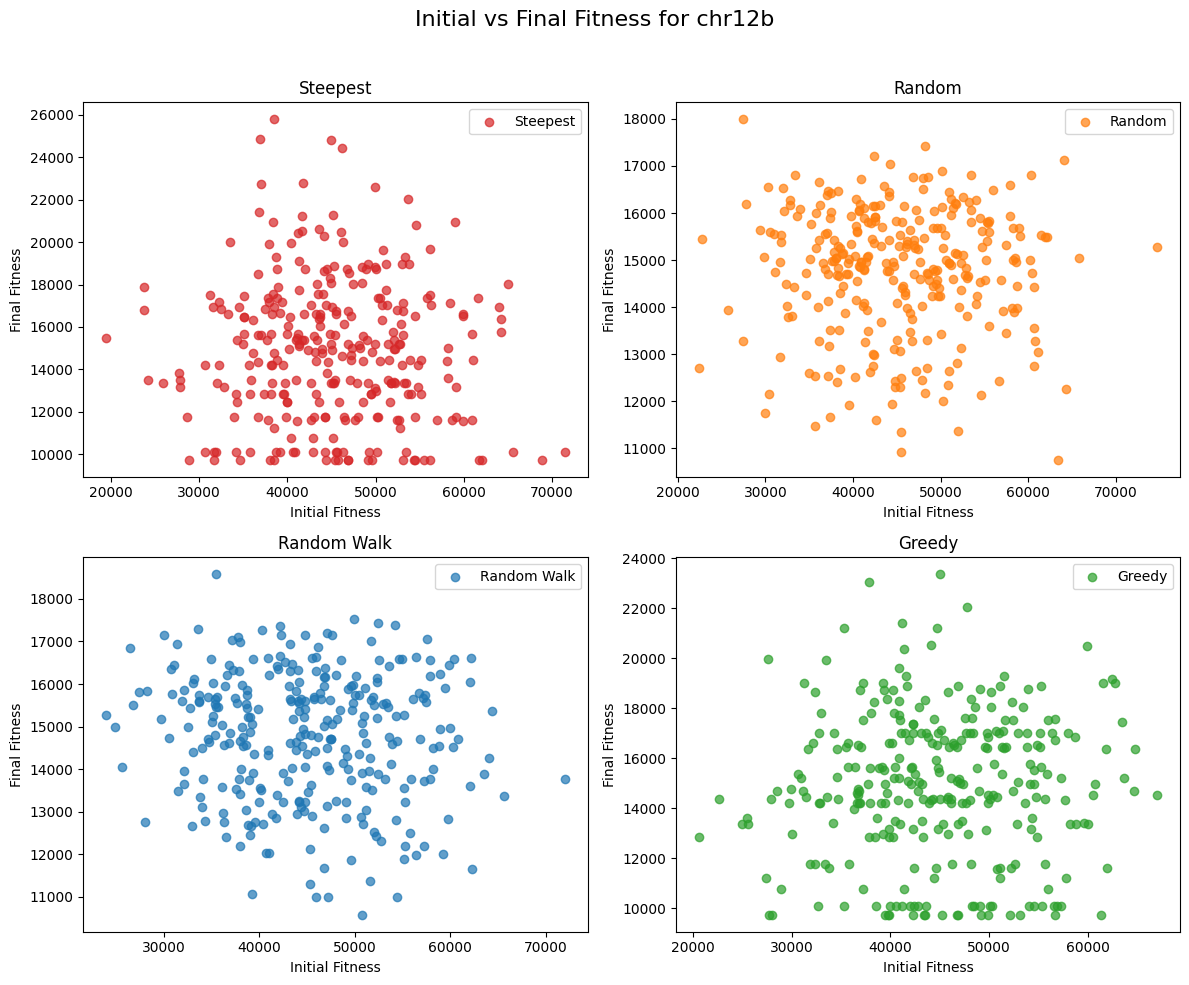

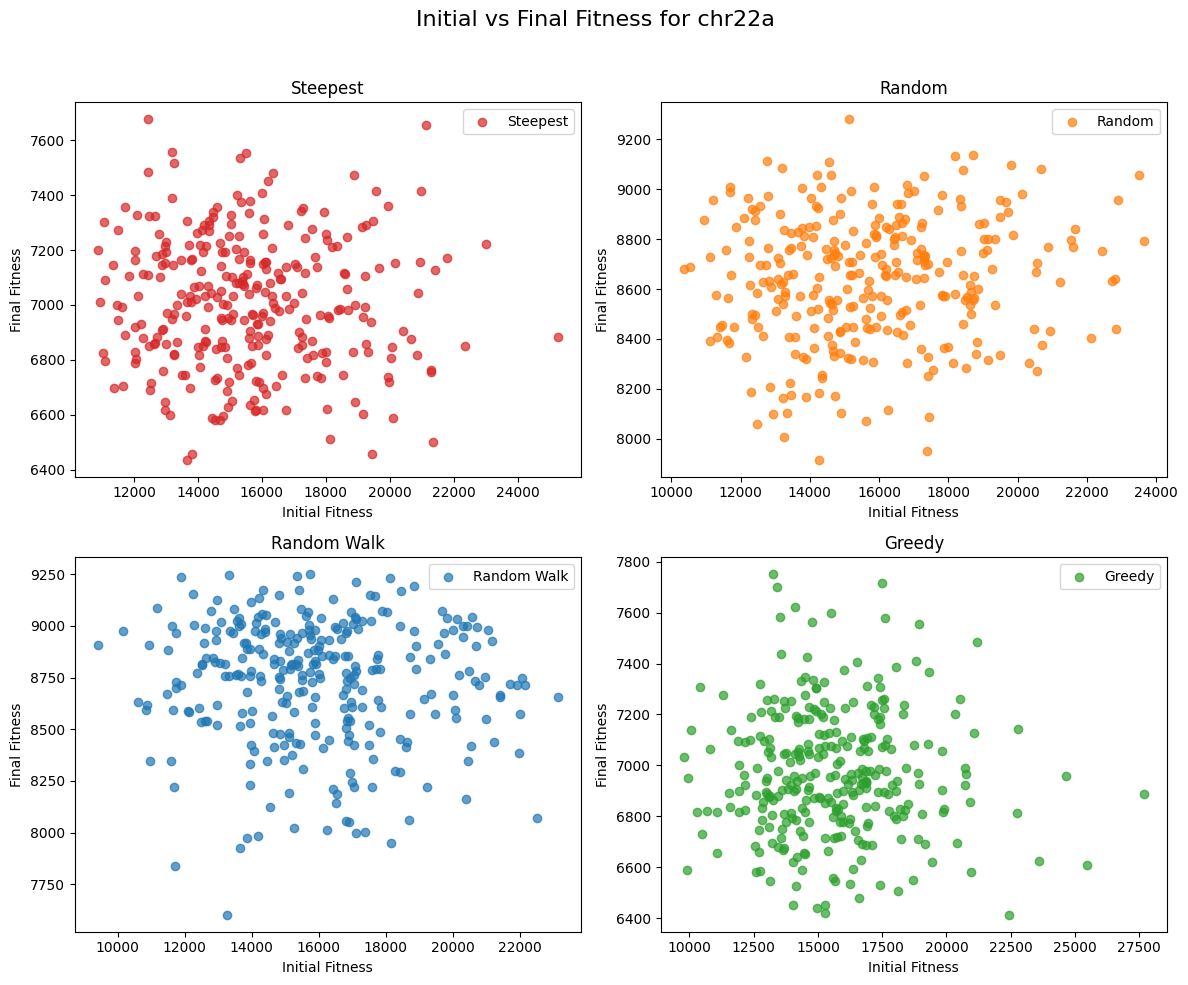

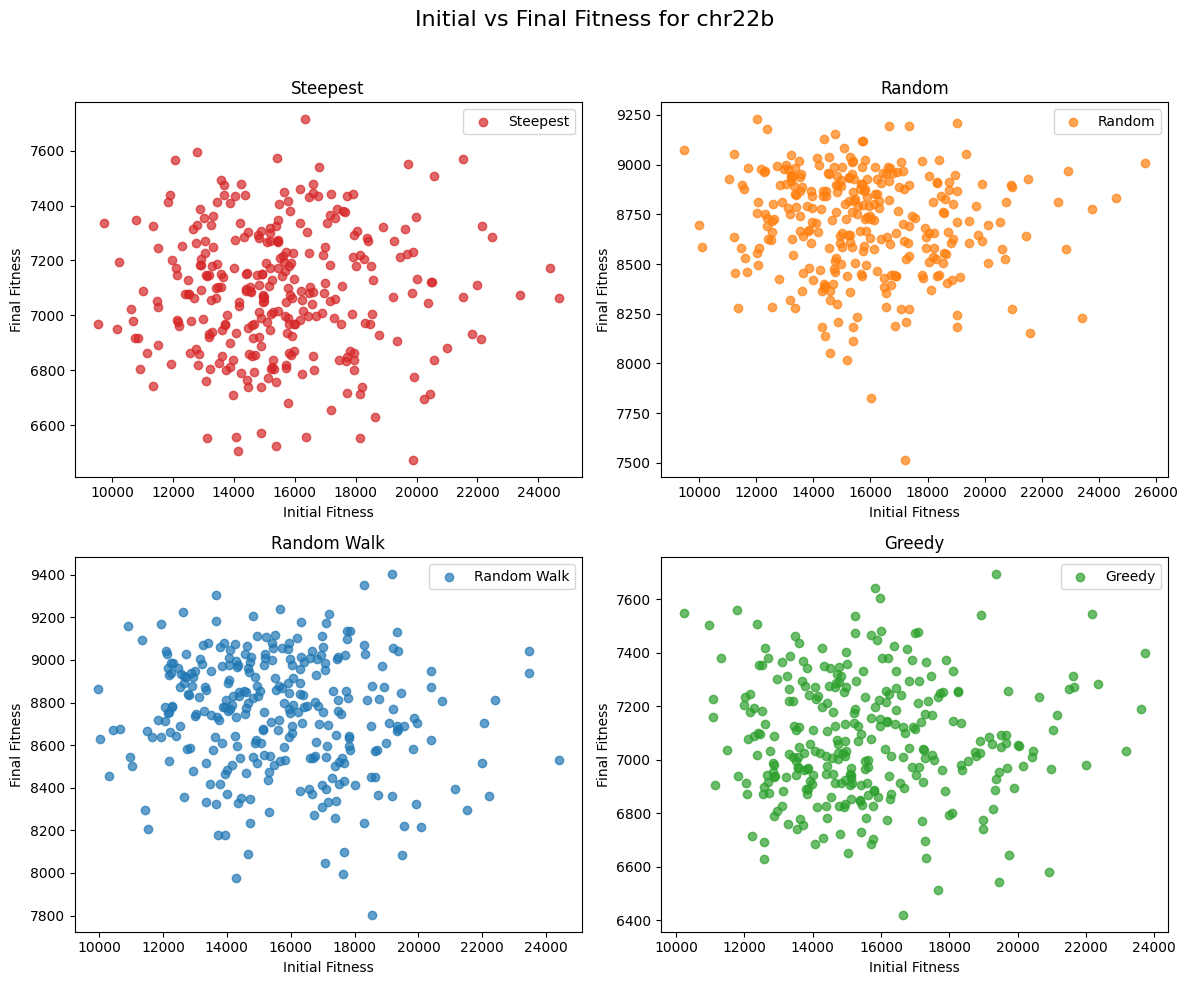

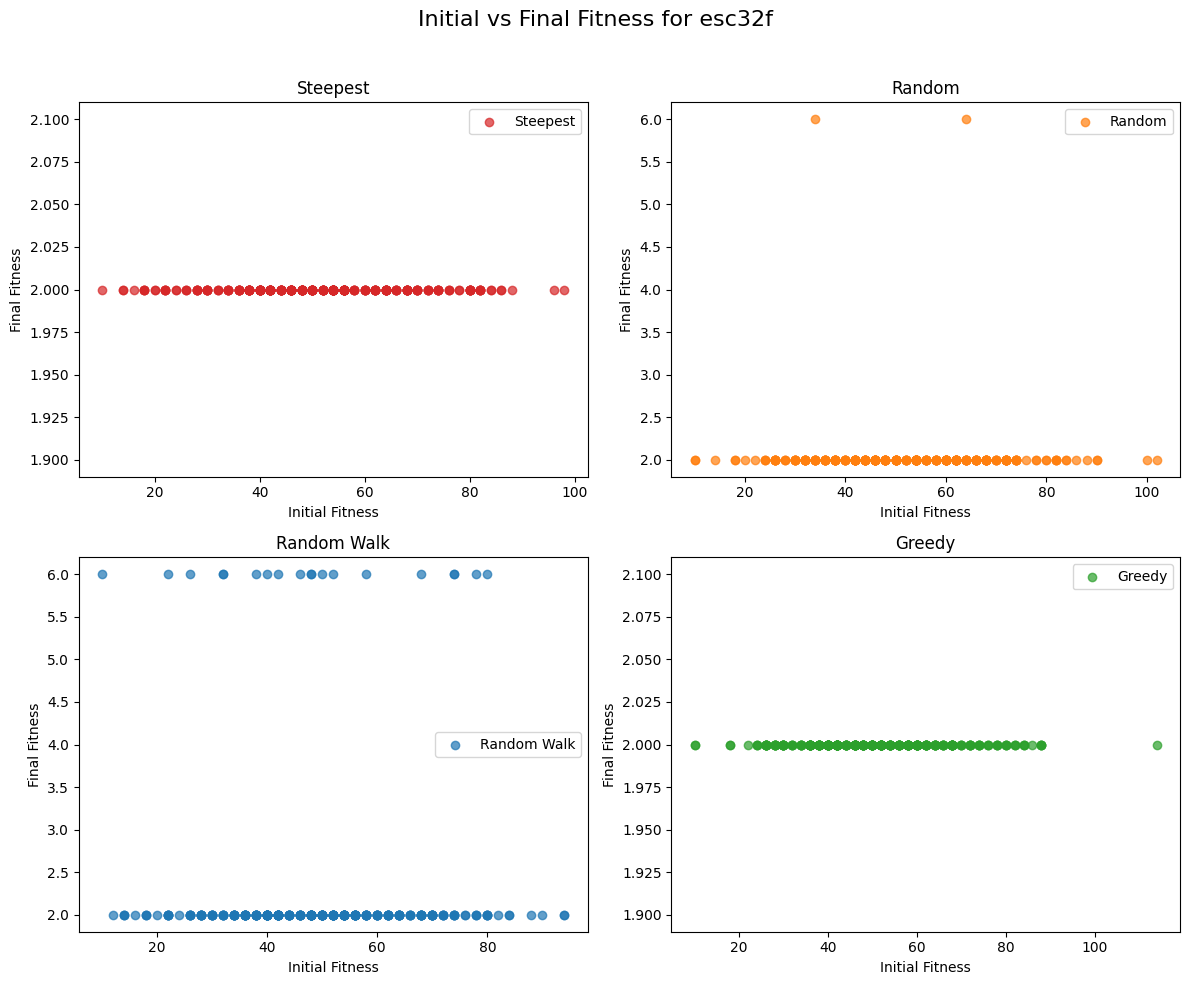

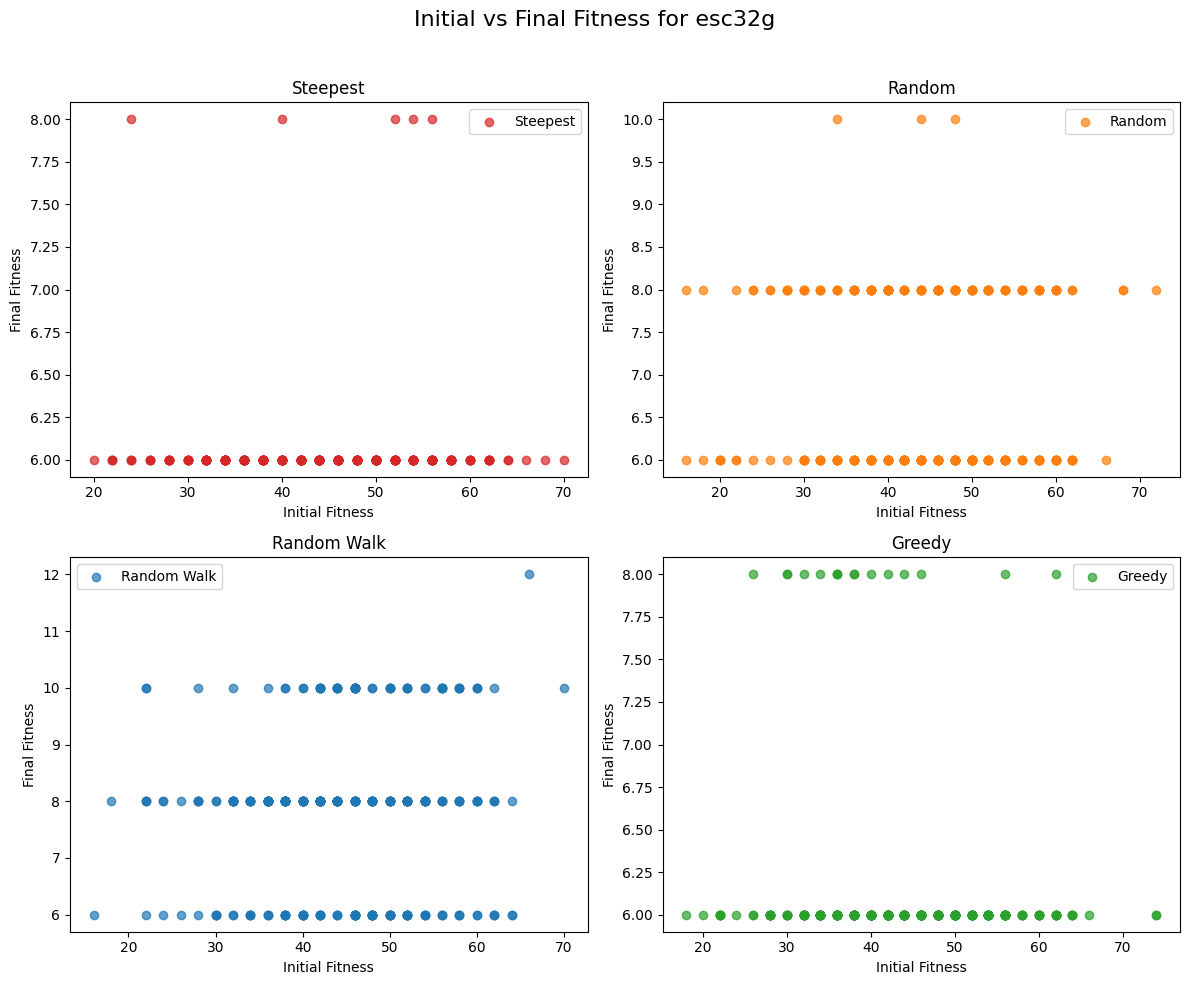

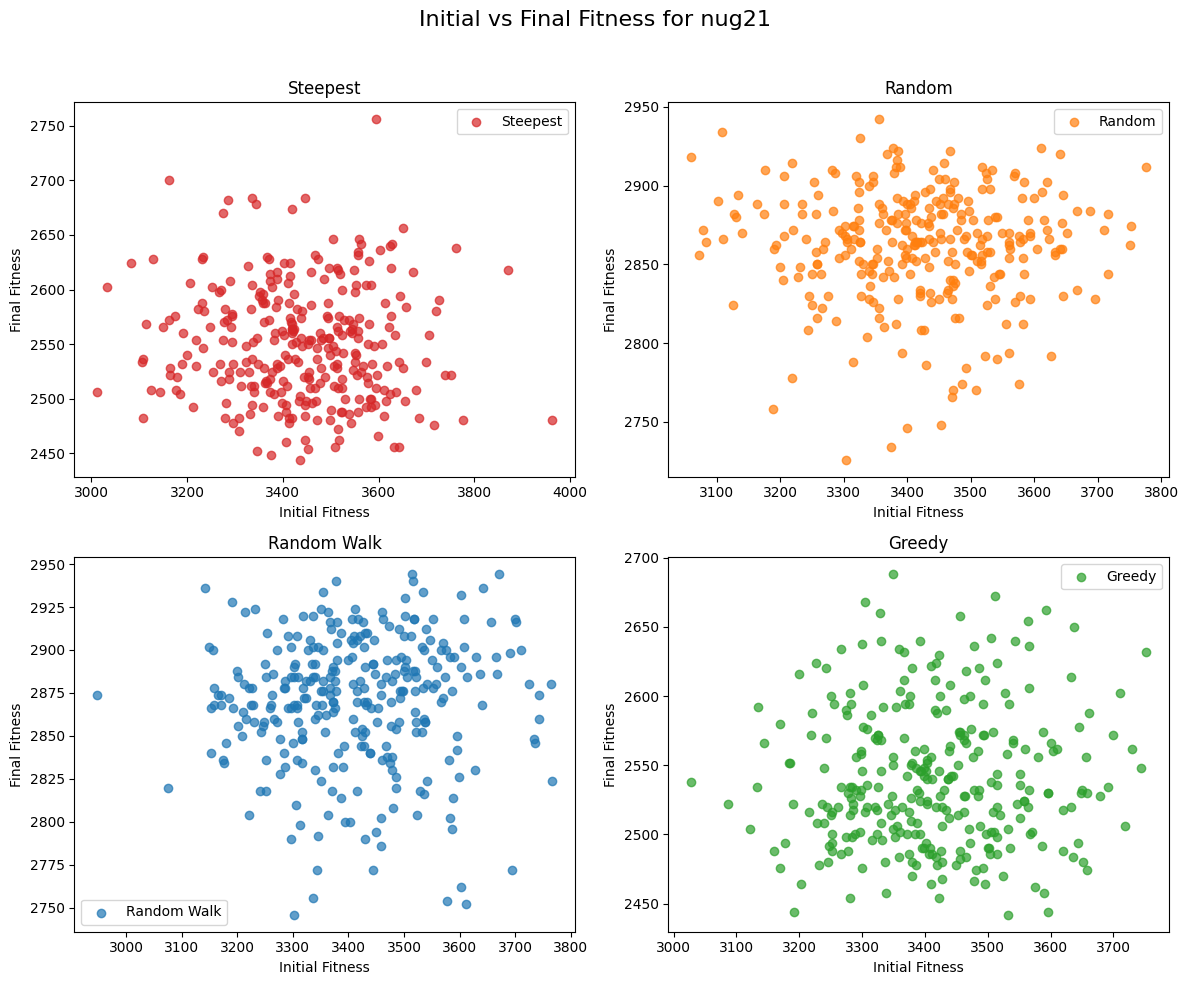

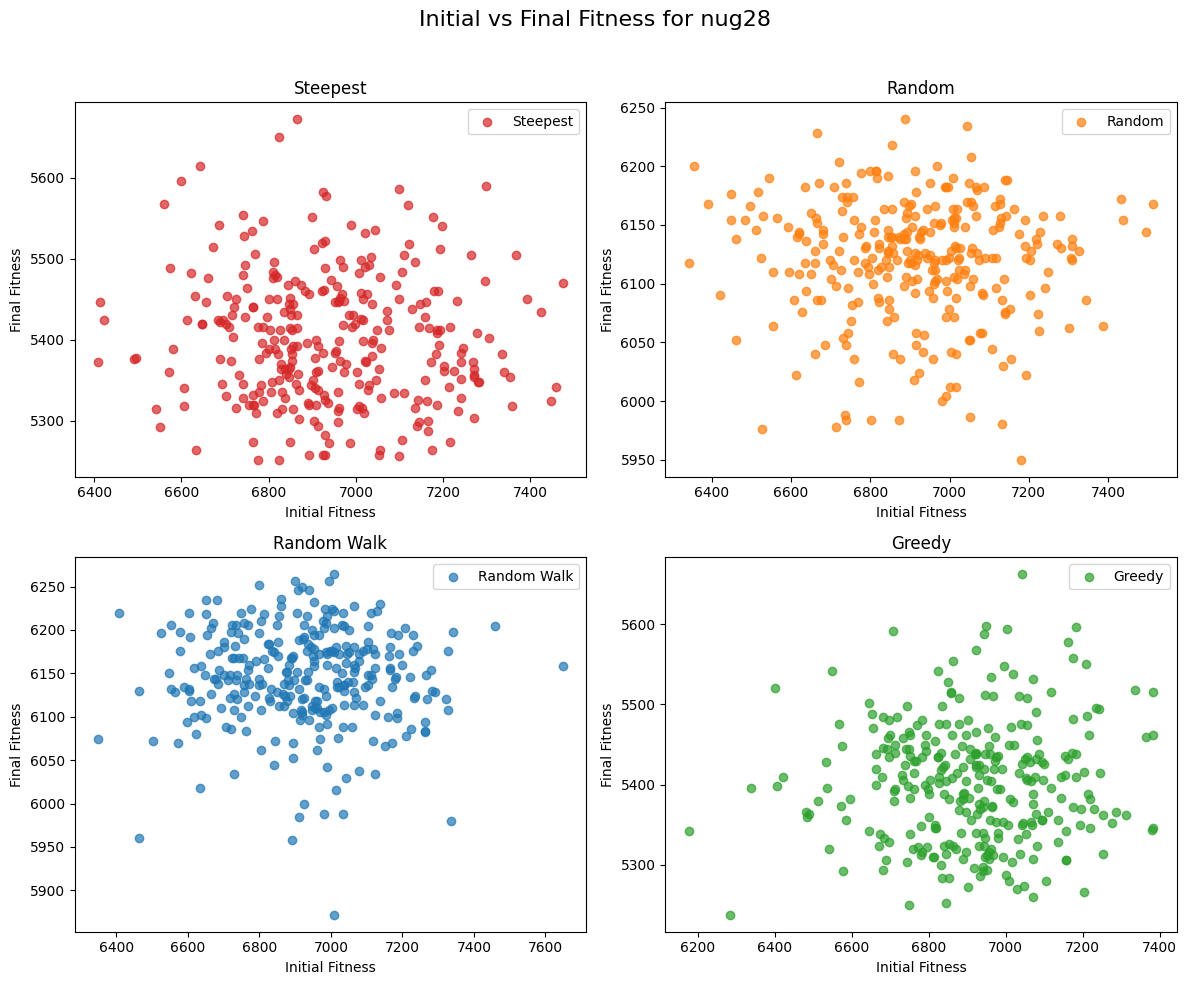

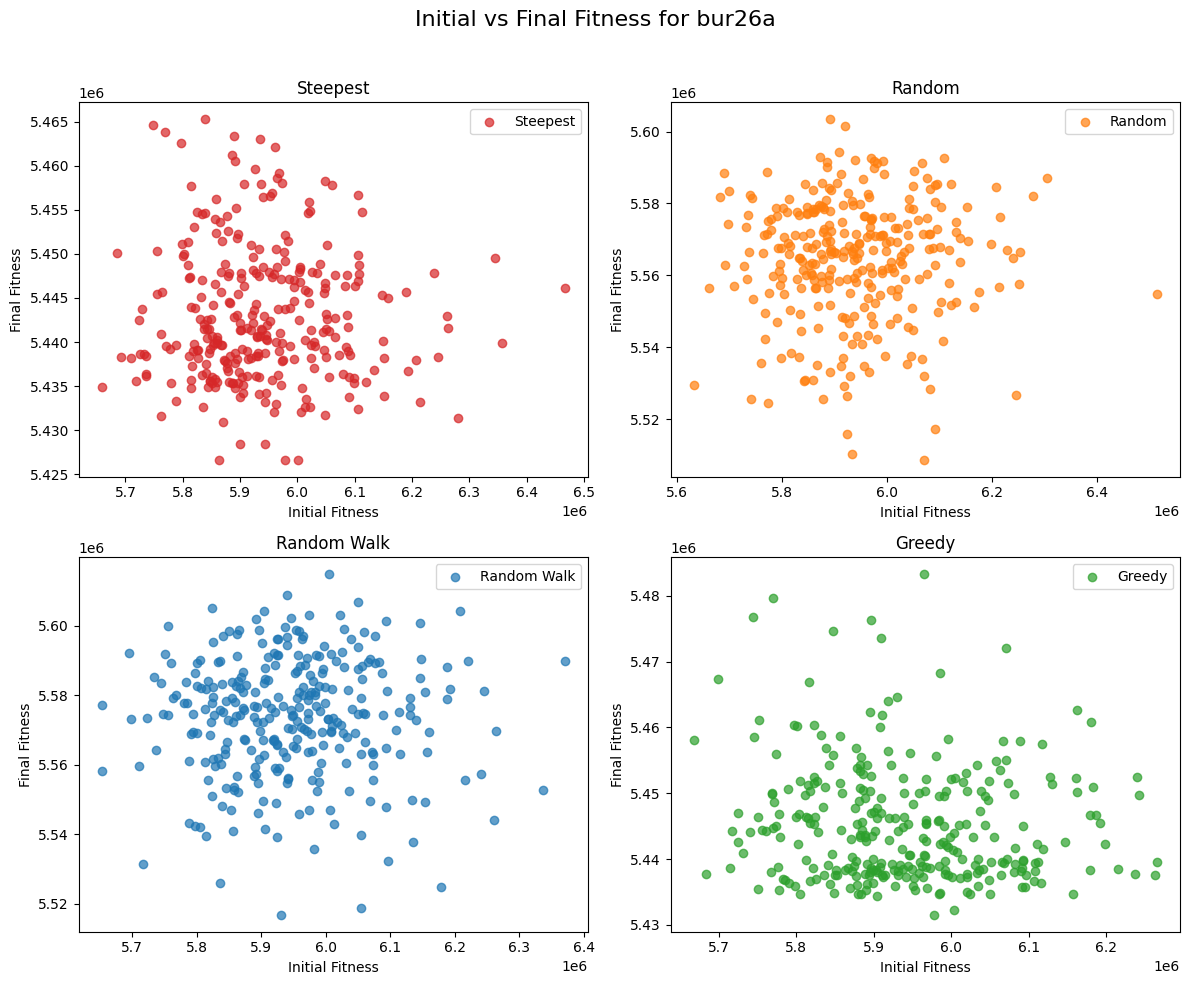

In [22]:
def plot_initial_vs_final_grid(df):
    solvers = [s for s in df['Solver'].unique() if s != "Heuristic"]
    instances = df['Instance'].unique()

    for instance in instances:
        instance_df = df[df['Instance'] == instance]
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))
        axs = axs.flatten()  # Flatten 2D array to 1D for easier indexing

        for i, solver in enumerate(solvers):
            solver_df = instance_df[instance_df['Solver'] == solver]
            ax = axs[i]

            ax.scatter(solver_df['InitialFitness'], solver_df['FinalFitness'],
                       label=solver, alpha=0.7, color=COLORS[solver])
            ax.set_title(solver)
            ax.set_xlabel("Initial Fitness")
            ax.set_ylabel("Final Fitness")
            ax.legend()

        # Hide any unused subplots (in case < 4 solvers)
        for j in range(len(solvers), 4):
            fig.delaxes(axs[j])

        instance_name = instance.split(sep=".")[0]

        fig.suptitle(f'Initial vs Final Fitness for {instance_name}', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
        plt.savefig(f'new_plots/initial_vs_final_{instance_name}.png')
        plt.show()

plot_initial_vs_final_grid(df)


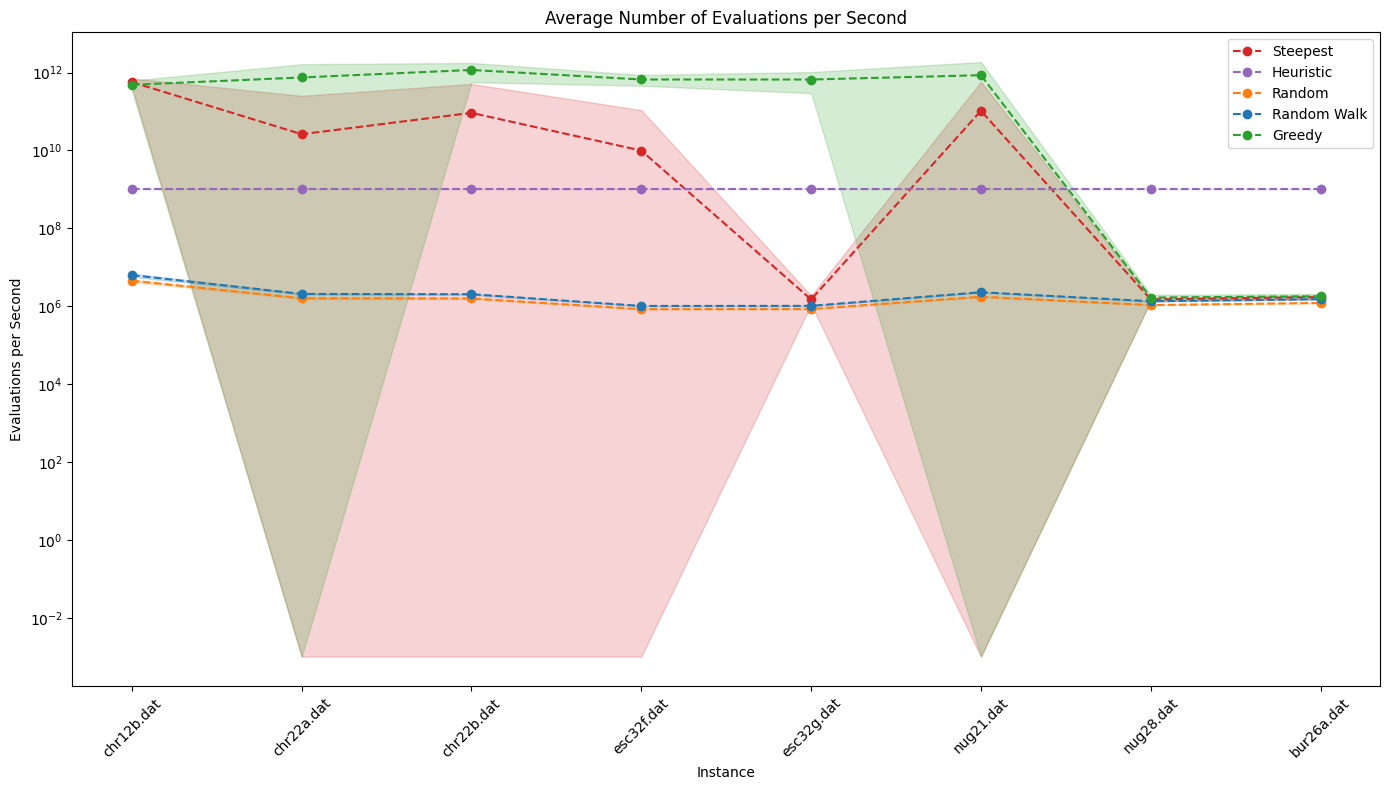

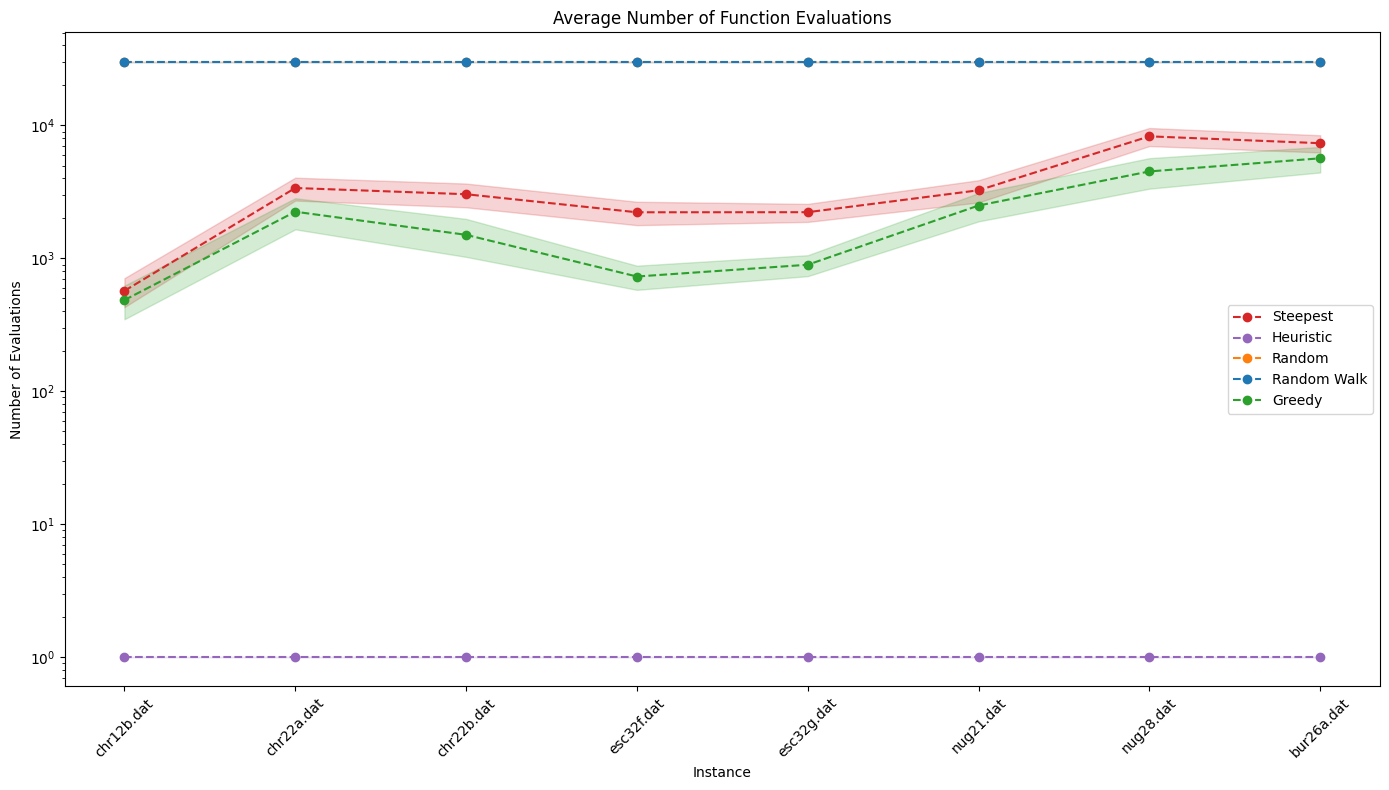

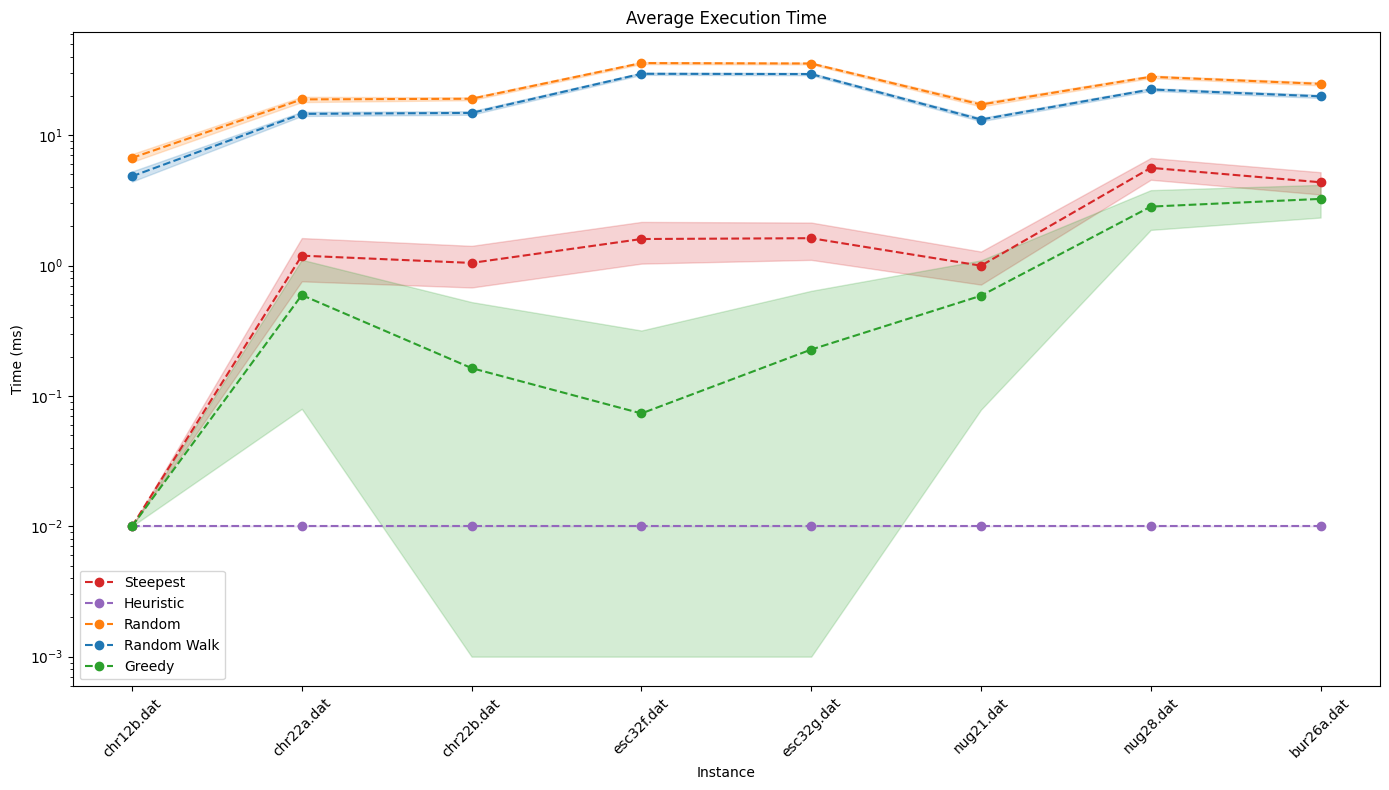

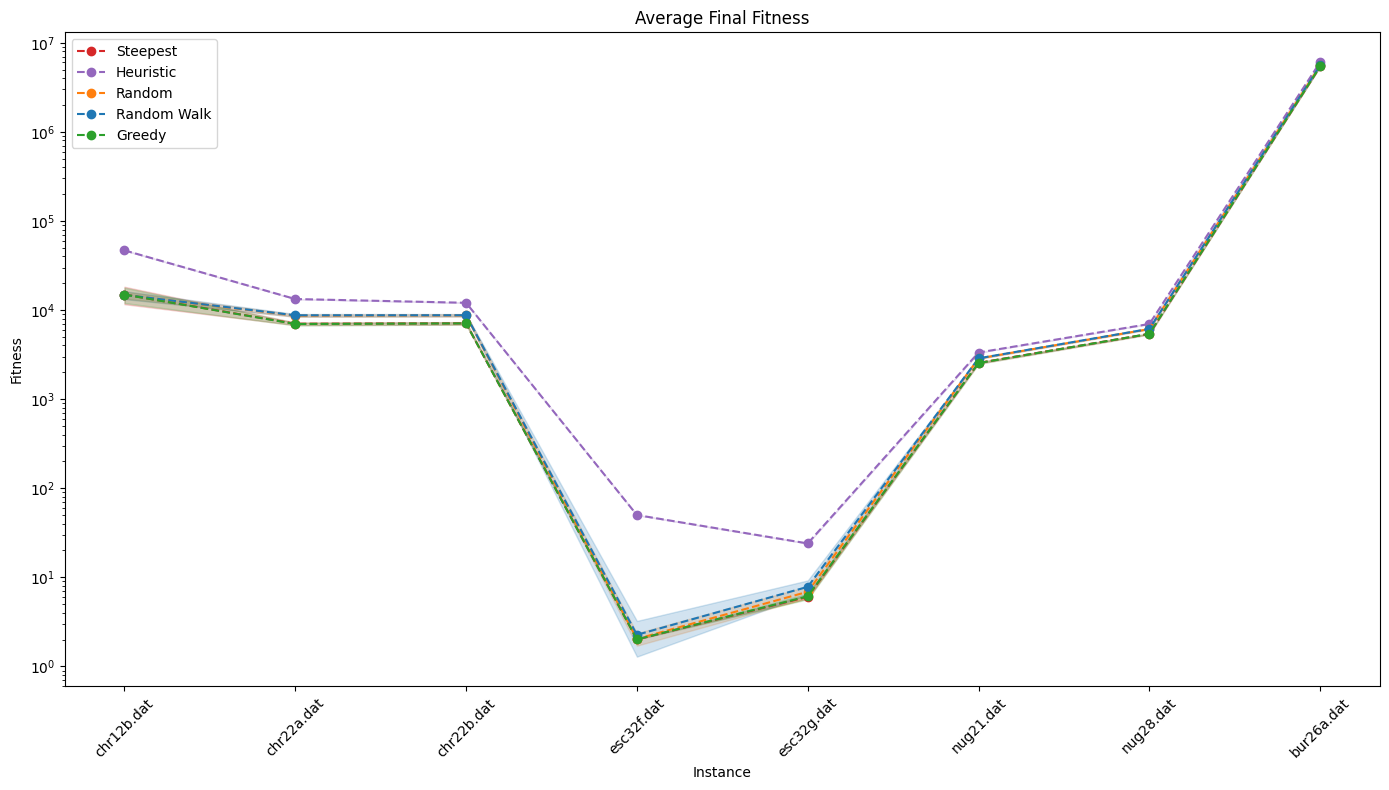

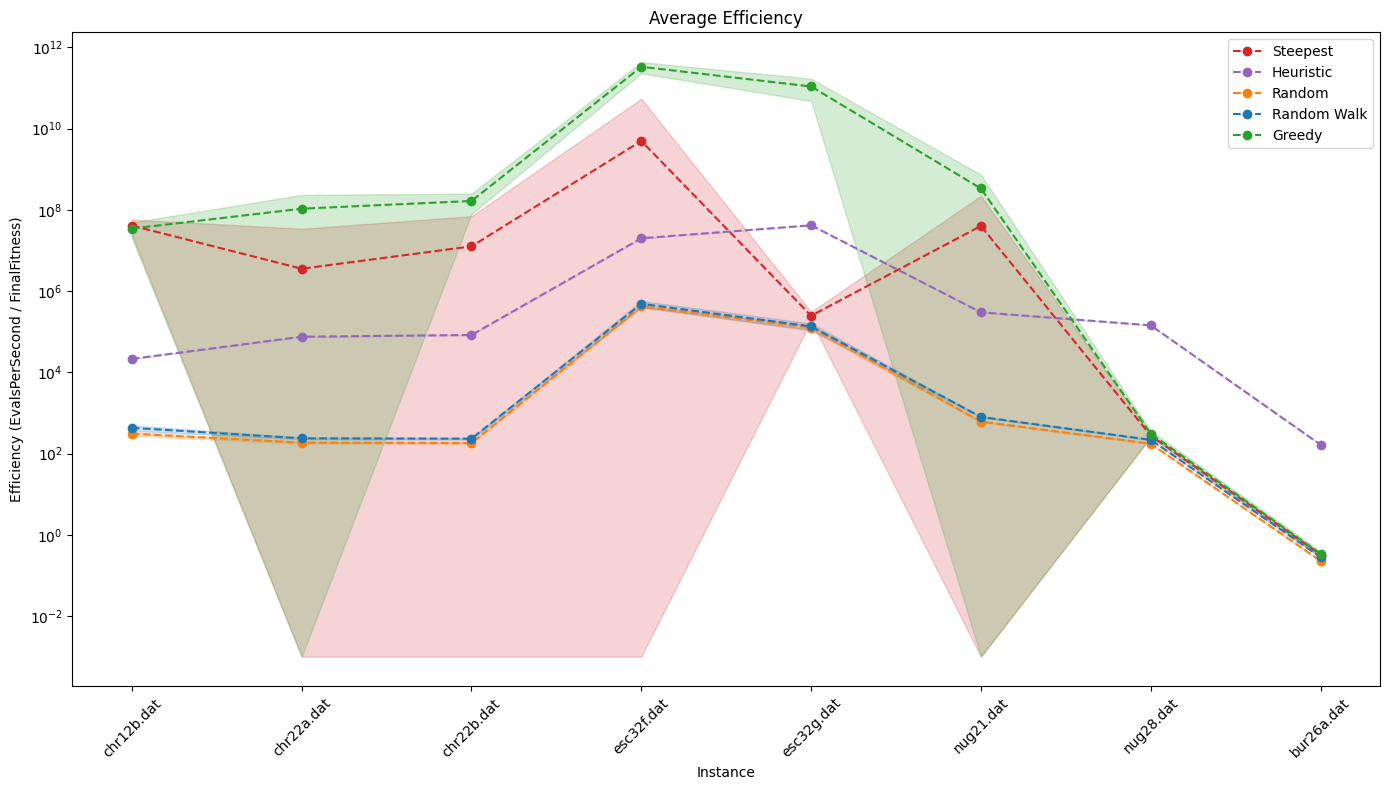

In [26]:
def plot_efficiencies(df):
    df['Efficiency'] = df['EvalsPerSecond'] / (df['FinalFitness'] + 1e-9)
    instances = df['Instance'].unique()
    solvers = df['Solver'].unique()

    metrics = {
        "evaluations_per_second.png": "EvalsPerSecond",
        "evaluations_count.png": "Evaluations",
        "execution_time.png": "TimeMs",
        "best_final.png": "FinalFitness",
        "efficiency.png": "Efficiency"
    }

    titles = {
        "evaluations_per_second.png": "Average Number of Evaluations per Second",
        "evaluations_count.png": "Average Number of Function Evaluations",
        "execution_time.png": "Average Execution Time",
        "best_final.png": "Average Final Fitness",
        "efficiency.png": "Average Efficiency"
    }

    y_labels = {
        "evaluations_per_second.png": "Evaluations per Second",
        "evaluations_count.png": "Number of Evaluations",
        "execution_time.png": "Time (ms)",
        "best_final.png": "Fitness",
        "efficiency.png": "Efficiency (EvalsPerSecond / FinalFitness)"
    }

    for filename, metric in metrics.items():
        plt.figure(figsize=(14, 8))

        for solver in solvers:
            means = []
            stds = []

            for instance in instances:
                filtered = df[(df["Solver"] == solver) & (df["Instance"] == instance)]
                if not filtered.empty:
                    mean_val = filtered[metric].mean()
                    std_val = filtered[metric].std()
                    means.append(mean_val + 1e-2)
                    stds.append(std_val)
                else:
                    means.append(np.nan)
                    stds.append(0)

            x = np.arange(len(instances))
            means = np.array(means)
            stds = np.array(stds)

            lower = means - stds
            upper = means + stds
            lower = np.where(lower <= 0, 1e-3, lower)  # Avoid log(0)

            plt.plot(x, means, label=solver, color=COLORS[solver], linestyle='--', marker='o')
            plt.fill_between(x, lower, upper, color=COLORS[solver], alpha=0.2)

        plt.xlabel('Instance')
        plt.ylabel(y_labels[filename])
        plt.title(titles[filename])
        plt.xticks(np.arange(len(instances)), instances, rotation=45)
        plt.yscale('log')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"new_plots/{filename}")
        plt.show()
        
plot_efficiencies(df)

/tmp/ipykernel_14899/3033968772.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  imp_data = df.groupby(['Instance', 'Solver'])['ImprovementPercent'].mean().reset_index()


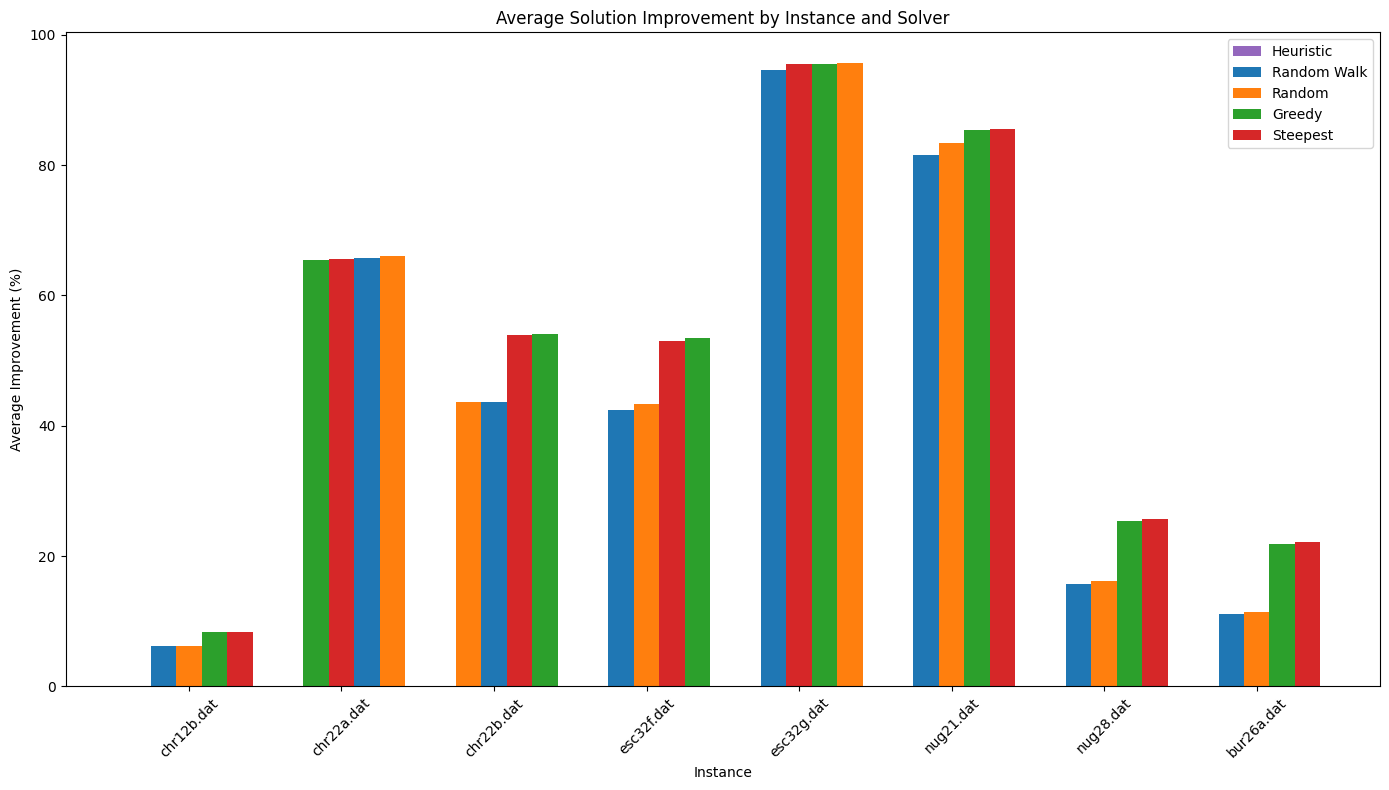

In [28]:
def plot_improvement_distribution(df):
    # Now plot improvement by instance
    plt.figure(figsize=(14, 8))
    
    # Group by instance and solver
    imp_data = df.groupby(['Instance', 'Solver'])['ImprovementPercent'].mean().reset_index()
    
    # For each solver, create a set of bars
    instances = df['Instance'].unique()
    solvers = df['Solver'].unique()
    width = 5 / len(solvers)
    offset = 0
    
    for instance in sorted(instances):
        instance_data = imp_data[imp_data['Instance'] == instance]
        
        # Sort solvers within the instance by ImprovementPercent
        instance_data = instance_data.sort_values(by="ImprovementPercent", ascending=True)
        
        # Plot each solver's improvement
        for i, solver in enumerate(instance_data['Solver']):
            solver_data = instance_data[instance_data['Solver'] == solver]
            x_position = offset + i 
            
            plt.bar(x_position, solver_data['ImprovementPercent'].values[0], width=width, label=solver if offset == 0 else "", color=COLORS[solver])
        
        offset += len(instance_data) + 1 
    
    plt.xlabel('Instance')
    plt.ylabel('Average Improvement (%)')
    plt.title('Average Solution Improvement by Instance and Solver')
    plt.xticks((np.arange(len(instances))*(len(solvers)+1))+(len(solvers)//2), instances, rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.savefig('new_plots/improvement_by_instance.png')
    plt.show()

plot_improvement_distribution(df)

In [51]:
df["optimal_solution"] = None

In [52]:
for index, row in df.iterrows():
    instance_value = row['Instance']
    
    # Check if 'Instance' value exists in the best_solutions dictionary
    if isinstance(instance_value, list):
        instance_value = str(instance_value)  # Convert list to a string, if needed

    # Assign the corresponding value from the dictionary to the new column
    if instance_value in best_solutions:
        df.at[index, 'optimal_solution'] = best_solutions[instance_value]
    else:
        df.at[index, 'optimal_solution'] = None

In [55]:
def normalized_kendalltau(row):
    # Extract the lists from the row
    solution = row['Solution']
    optimal_solution = row['optimal_solution']
    
    # Calculate Kendall tau correlation
    tau, p_value = kendalltau(solution, optimal_solution)
    
    # Return the tau value (which is already normalized between -1 and 1)
    return tau

# Apply the function to each row and create a new column
df['normalized_kendalltau'] = df.apply(normalized_kendalltau, axis=1)

In [61]:
df.sort_values(by="normalized_kendalltau", ascending=False)

,Instance,Solver,Run,InitialFitness,FinalFitness,TimeMs,Steps,Evaluations,SolutionsChecked,Solution,GapToBest,ImprovementPercent,EvalsPerSecond,Efficiency,optimal_solution,kendall_tau_distance,normalized_kendalltau
1,chr12b.dat,Steepest,2,46854,9742,0.0,9,594,594,"[4, 6, 0, 9, 10, 2, 3, 1, 8, 5, 11, 7]",0.000000,79.207752,5.940000e+11,6.097311e+07,"[5, 7, 1, 10, 11, 3, 4, 2, 9, 6, 12, 8]",NaN,1.000000
20,chr12b.dat,Steepest,21,54454,9742,0.0,15,990,990,"[4, 6, 0, 9, 10, 2, 3, 1, 8, 5, 11, 7]",0.000000,82.109671,9.900000e+11,1.016218e+08,"[5, 7, 1, 10, 11, 3, 4, 2, 9, 6, 12, 8]",NaN,1.000000
1229,chr12b.dat,Greedy,30,49146,9742,0.0,16,470,470,"[4, 6, 0, 9, 10, 2, 3, 1, 8, 5, 11, 7]",0.000000,80.177431,4.700000e+11,4.824471e+07,"[5, 7, 1, 10, 11, 3, 4, 2, 9, 6, 12, 8]",NaN,1.000000
1239,chr12b.dat,Greedy,40,43436,9742,0.0,24,649,649,"[4, 6, 0, 9, 10, 2, 3, 1, 8, 5, 11, 7]",0.000000,77.571600,6.490000e+11,6.661876e+07,"[5, 7, 1, 10, 11, 3, 4, 2, 9, 6, 12, 8]",NaN,1.000000
44,chr12b.dat,Steepest,45,53156,9742,0.0,12,792,792,"[4, 6, 0, 9, 10, 2, 3, 1, 8, 5, 11, 7]",0.000000,81.672812,7.920000e+11,8.129747e+07,"[5, 7, 1, 10, 11, 3, 4, 2, 9, 6, 12, 8]",NaN,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10175,nug28.dat,Steepest,276,6606,5340,6.0,24,9072,9072,"[3, 5, 19, 27, 6, 8, 17, 18, 16, 9, 24, 7, 14,...",3.368177,19.164396,1.512000e+06,2.831460e+02,"[18, 21, 9, 1, 28, 20, 11, 3, 13, 12, 10, 19, ...",NaN,-0.624339
10147,nug28.dat,Steepest,248,7136,5496,5.0,18,6804,6804,"[9, 7, 14, 27, 0, 2, 18, 16, 12, 19, 17, 4, 25...",6.387921,22.982063,1.360800e+06,2.475982e+02,"[18, 21, 9, 1, 28, 20, 11, 3, 13, 12, 10, 19, ...",NaN,-0.640212
9779,nug28.dat,Greedy,180,6890,5422,2.0,53,3843,3843,"[17, 7, 18, 27, 0, 8, 24, 19, 15, 16, 12, 10, ...",4.955478,21.306241,1.921499e+06,3.543893e+02,"[18, 21, 9, 1, 28, 20, 11, 3, 13, 12, 10, 19, ...",NaN,-0.687831
731,chr12b.dat,Random,132,40870,16730,6.0,30000,30000,30000,"[6, 4, 11, 1, 3, 9, 8, 10, 7, 5, 2, 0]",71.730651,59.065329,4.999999e+06,2.988643e+02,"[5, 7, 1, 10, 11, 3, 4, 2, 9, 6, 12, 8]",NaN,-0.727273


/tmp/ipykernel_14899/1638279250.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  imp_data = df.groupby(['Instance', 'Solver'])['normalized_kendalltau'].median().reset_index()


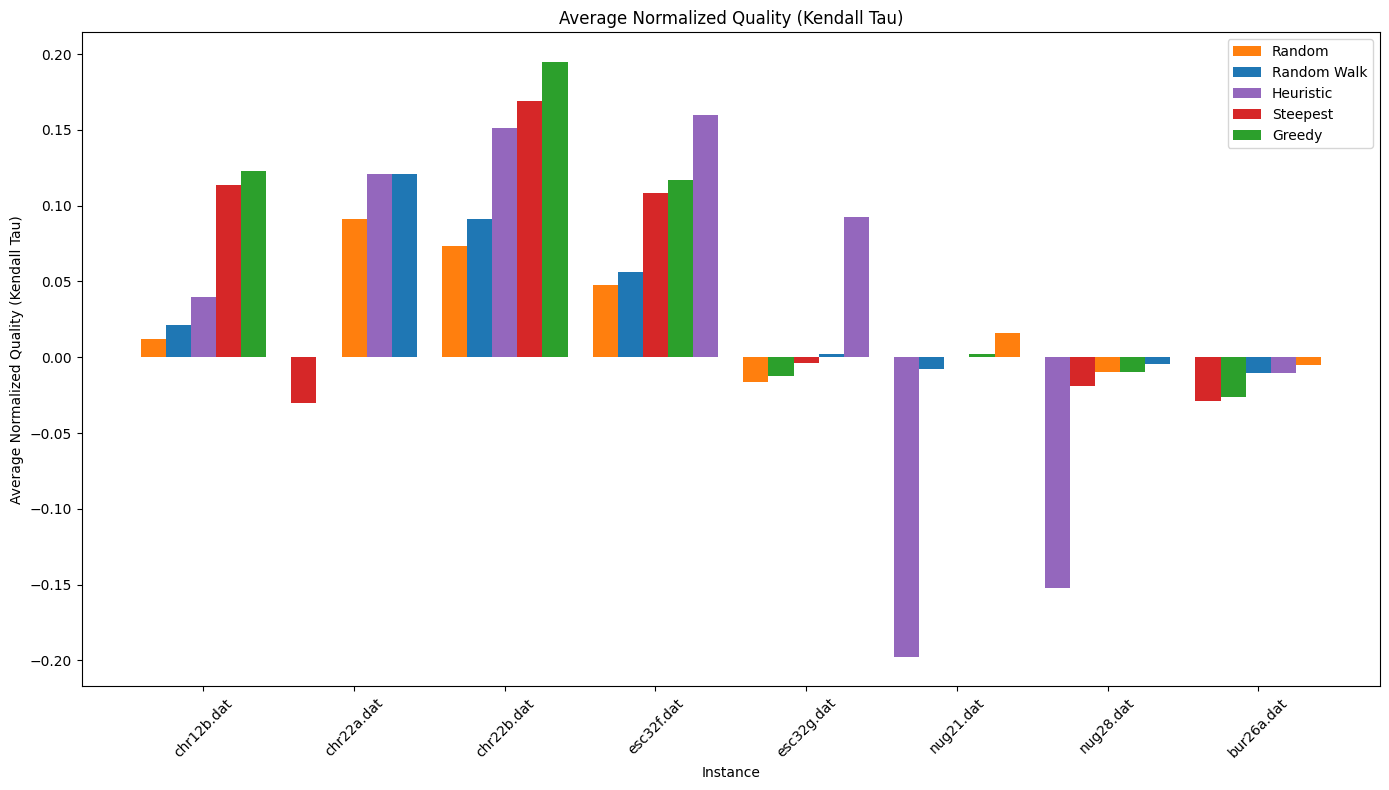

In [ ]:
def plot_improvement_distribution(df):
    # Now plot improvement by instance
    plt.figure(figsize=(14, 8))
    
    # Group by instance and solver
    imp_data = df.groupby(['Instance', 'Solver'])['normalized_kendalltau'].mean().reset_index()
    
    # For each solver, create a set of bars
    instances = df['Instance'].unique()
    solvers = df['Solver'].unique()
    width = 5 / len(solvers)
    offset = 0
    
    for instance in sorted(instances):
        instance_data = imp_data[imp_data['Instance'] == instance]
        
        # Sort solvers within the instance by ImprovementPercent
        instance_data = instance_data.sort_values(by="normalized_kendalltau", ascending=True)
        
        # Plot each solver's improvement
        for i, solver in enumerate(instance_data['Solver']):
            solver_data = instance_data[instance_data['Solver'] == solver]
            x_position = offset + i 
            
            plt.bar(x_position, solver_data['normalized_kendalltau'].values[0], width=width, label=solver if offset == 0 else "", color=COLORS[solver])
        
        offset += len(instance_data) + 1 
    
    plt.xlabel('Instance')
    plt.ylabel('Average Normalized Quality (Kendall Tau)')
    plt.title('Average Normalized Quality (Kendall Tau)')
    plt.xticks((np.arange(len(instances))*(len(solvers)+1))+(len(solvers)//2), instances, rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.savefig('new_plots/quality.png')
    plt.show()

plot_improvement_distribution(df)